In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:19<00:00, 126MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Dataset Path:", path)


Dataset Path: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler,random_split, ConcatDataset, Subset
from torch import nn, optim
from torch.cuda import amp
from torchvision import datasets, transforms, models
from torch.cuda.amp import autocast, GradScaler
import torch.optim.lr_scheduler as lr_scheduler

In [ ]:
# Dataset Paths
path = "/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2"  # Replace with the output path from kagglehub
train_dir = os.path.join(path, "train")
val_dir = os.path.join(path, "val")
test_dir = os.path.join(path, "test")
import os

print(os.listdir(path))


['chest_xray']


In [ ]:
train_dir = os.path.join(path, "chest_xray", "train")
val_dir = os.path.join(path, "chest_xray", "val")
test_dir = os.path.join(path, "chest_xray", "test")


In [ ]:
import os
print("Train Directory Exists:", os.path.exists(train_dir))
print("Validation Directory Exists:", os.path.exists(val_dir))
print("Test Directory Exists:", os.path.exists(test_dir))


Train Directory Exists: True
Validation Directory Exists: True
Test Directory Exists: True


In [ ]:
print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

Train set:
PNEUMONIA=3875
NORMAL=1341


In [ ]:
print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

Test set:
PNEUMONIA=390
NORMAL=234


In [ ]:
print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

Validation set:
PNEUMONIA=8
NORMAL=8


In [ ]:
# Augmentation for training data (convert to grayscale with 1 channel)
train_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((1024, 1024)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (1 channel)
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),  # Normalize 1 channel
])

In [ ]:
# Common transformations for validation and testing hande unbalance (keep as grayscale)
common_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),
])

In [ ]:
# Load datasets from directories with respective transformations
train_dataset_raw = datasets.ImageFolder(root=train_dir, transform=train_augmentation)
val_dataset_raw = datasets.ImageFolder(root=val_dir, transform=common_transform)
test_dataset_raw = datasets.ImageFolder(root=test_dir, transform=common_transform)


In [ ]:
# Combine all datasets
combined_dataset = ConcatDataset([train_dataset_raw, val_dataset_raw, test_dataset_raw])

# Shuffle and split combined dataset into 80% train, 10% validation, and 10% test
total_size = len(combined_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  # Ensure no data is lost

# Create a torch.Generator for reproducibility
torch_gen = torch.Generator().manual_seed(42)

# Split the dataset
train_indices, val_indices, test_indices = random_split(
    range(total_size), [train_size, val_size, test_size], generator=torch_gen
)

In [ ]:
# Define datasets with respective subsets
train_dataset = Subset(combined_dataset, train_indices)
val_dataset = Subset(combined_dataset, val_indices)
test_dataset = Subset(combined_dataset, test_indices)

In [ ]:
# Create a WeightedRandomSampler for the training dataset
train_targets = [train_dataset.dataset[i][1] for i in train_indices]  # Get class indices for training samples

# Compute class counts and weights
class_counts = np.bincount(train_targets)  # Count occurrences of each class
class_weights = 1.0 / class_counts  # Inverse of class counts
sample_weights = np.array([class_weights[target] for target in train_targets])  # Assign weights to samples

# Initialize the WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)


In [ ]:
# DataLoaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Print out the number of images in each set
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

Number of training images: 4684
Number of validation images: 585
Number of test images: 587


In [ ]:
# Iterate over one batch from the train_loader to check the shape of images and labels
for images, labels in train_loader:
    print(f"Image batch shape: {images.size()}")
    print(f"Labels batch shape: {labels.size()}")
    break  # Exit the loop after one batch (remove this to see all batches)

Image batch shape: torch.Size([16, 1, 1024, 1024])
Labels batch shape: torch.Size([16])


In [ ]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

Tesla T4
True


In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
class XRayCNN(nn.Module):
    def __init__(self):
        super(XRayCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.batch_norm4 = nn.BatchNorm2d(128)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 2)

        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.batch_norm1(self.relu(self.conv1(x))))
        x = self.pool(self.batch_norm2(self.relu(self.conv2(x))))
        x = self.pool(self.batch_norm3(self.relu(self.conv3(x))))
        x = self.pool(self.batch_norm4(self.relu(self.conv4(x))))

        x = self.global_pool(x)
        x = x.view(-1, 128)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Initialize model, move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instantiate the model and move it to the GPU
model = XRayCNN().to(device)

In [ ]:
# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Use GradScaler for mixed precision training
scaler = GradScaler()


<ipython-input-26-b44b57074250>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
# Hyperparameters
num_epochs = 10
accumulation_steps = 4

In [ ]:
# Lists to store losses and accuracies for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    optimizer.zero_grad()

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass with mixed precision
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # Update weights after every accumulation_steps batches
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy for the epoch
    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_train_accuracy = (correct_train / total_train) * 100
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation Phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            running_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy for the epoch
    epoch_val_loss = running_val_loss / len(val_loader)
    epoch_val_accuracy = (correct_val / total_val) * 100
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    # Learning rate adjustment
    scheduler.step(epoch_val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%")
    print(f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.2f}%")

<ipython-input-28-e9dfc461e2fd>:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-28-e9dfc461e2fd>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/10]
Train Loss: 0.3588, Train Accuracy: 84.95%
Validation Loss: 0.5851, Validation Accuracy: 77.61%
Epoch [2/10]
Train Loss: 0.2429, Train Accuracy: 90.99%
Validation Loss: 0.1881, Validation Accuracy: 92.82%
Epoch [3/10]
Train Loss: 0.2026, Train Accuracy: 92.95%
Validation Loss: 0.2006, Validation Accuracy: 93.68%
Epoch [4/10]
Train Loss: 0.1717, Train Accuracy: 93.72%
Validation Loss: 0.1513, Validation Accuracy: 94.02%
Epoch [5/10]
Train Loss: 0.1882, Train Accuracy: 93.13%
Validation Loss: 0.1399, Validation Accuracy: 94.36%
Epoch [6/10]
Train Loss: 0.1595, Train Accuracy: 94.15%
Validation Loss: 0.2863, Validation Accuracy: 87.01%
Epoch [7/10]
Train Loss: 0.1531, Train Accuracy: 94.45%
Validation Loss: 0.5858, Validation Accuracy: 81.03%
Epoch [8/10]
Train Loss: 0.1549, Train Accuracy: 94.56%
Validation Loss: 0.2843, Validation Accuracy: 87.86%
Epoch [9/10]
Train Loss: 0.1409, Train Accuracy: 95.18%
Validation Loss: 0.1310, Validation Accuracy: 94.87%
Epoch [10/10]
Train

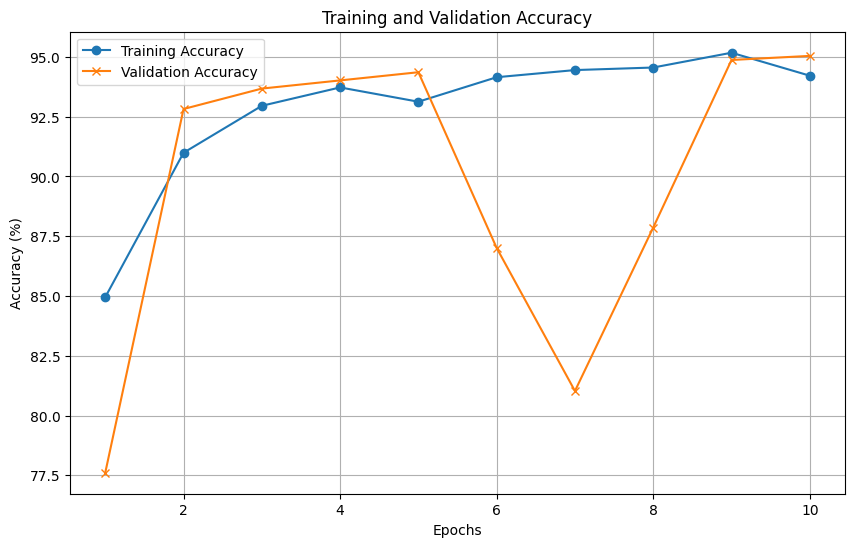

In [ ]:
# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

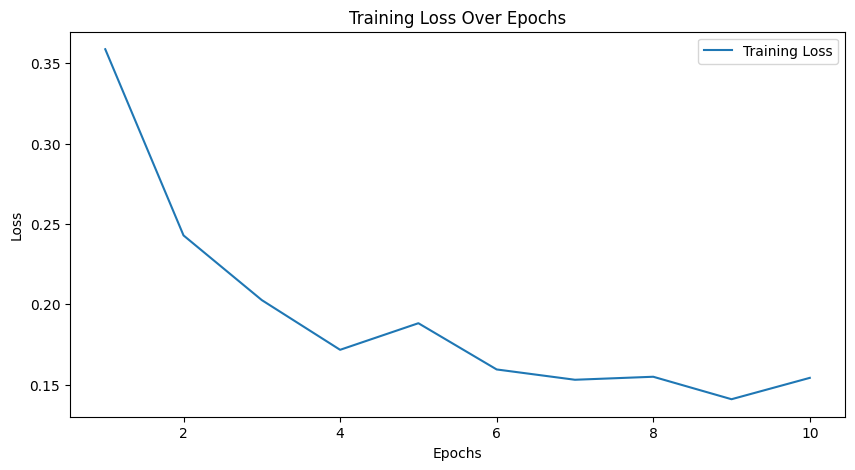

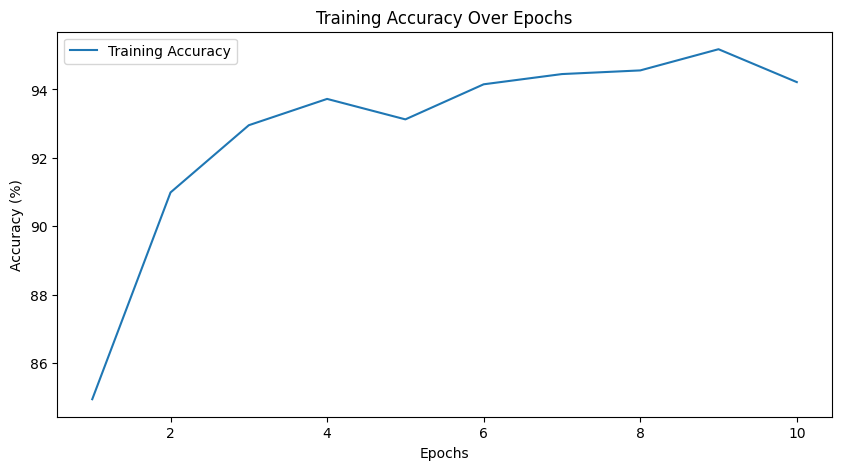

In [ ]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


Confusion Matrix:
[[151  13]
 [ 26 397]]


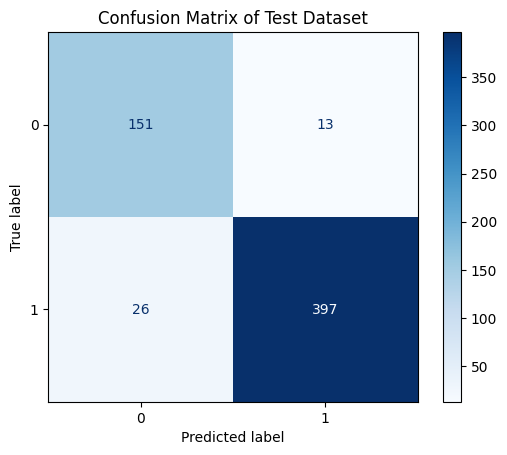

Sensitivity (Recall): 0.9385
Specificity: 0.9207
Precision: 0.9683
F1-Score: 0.9532


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# Initialize lists to store true and predicted labels
all_labels = []
all_predictions = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get the predicted class by taking the class with the highest score
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix of Test Dataset')
plt.show()


TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

# Sensitivity (Recall): True Positive Rate
sensitivity = TP / (TP + FN)
# Specificity: True Negative Rate
specificity = TN / (TN + FP)
# Precision: When it predicts positive, how often is it correct?
precision = TP / (TP + FP)
# F1 Score: Harmonic mean of precision and recall
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

# Print calculated metrics
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to calculate accuracy
correct = 0
total = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    # Iterate over the test data
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get the predicted class by taking the class with the highest score
        _, predicted = torch.max(outputs, 1)

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
# Calculate accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 94.04%


In [ ]:
# Define the path to save the model
model_save_path = "xray_cnn_model.pth"

# Save the model's state_dict (parameters)
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to xray_cnn_model.pth
